In [1]:
import matplotlib.pyplot as plt
from src.plot_utils import *
from src.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"

In [2]:
# # PLOT defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["xtick.minor.size"] = 1.0
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["xtick.minor.width"] = 0.18
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

## MANC 1024x DNg100 pruning

In [3]:
simType = "DNg100_Stim_Prune"
simPath = simType+"/hyak/run_id=28177996"
folder = dataPath + simPath
minicircuits = sparse.load_npz(folder+f"/ckpt/{simType}_mini_circuits.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
minicircuits = minicircuits[dataset]
nRuns = minicircuits.shape[0]

wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [4]:
minicircuitsDf = pd.DataFrame(data=minicircuits,columns = wTable.bodyId)
minicircuitsDf = minicircuitsDf.iloc[:,np.argsort(np.sum(minicircuitsDf.values, 0))]
minicircuitsDf[10093] = False #exclude DNg100
minicircuitsDf

bodyId,25128,25214,25181,25176,25172,25171,25160,25155,25130,25238,...,10342,11799,19862,10242,12026,10715,13905,11751,10093,10707
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
1020,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
1021,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
1022,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True


In [5]:
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

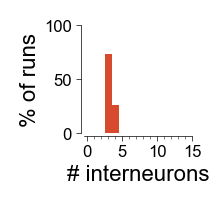

In [6]:
ax = sns.histplot(minicircuitsDf.sum(1),color=excColor,bins=np.arange(90),edgecolor=None,stat="percent",alpha=1,discrete=True)
ax.set_xlim(-0.5,14.5)
# ax.set_xlim(0,30)
# plt.yticks(np.arange(0,20,4))
ax.set_xlabel("# interneurons")
ax.set_ylabel("% of runs")
ax.set_xticks(np.arange(0,16,5))
ax.set_xticks(np.arange(0,16,1),minor=True,)
ax.tick_params(axis='both', which='major')
ax.spines[["top","right"]].set_visible(False)

plt.ylim([0,100])

fig = plt.gcf()
fig.set_figheight(0.7)
fig.set_figwidth(0.7)
# plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/minicircuitNIns.svg",transparent=True)
plt.show()

In [7]:
orderedInPrevalences = minicircuitsDf.transpose().sum(1).sort_values(ascending=False)
orderedInPcts = orderedInPrevalences / nRuns * 100
orderedInNts = orderedInPcts.index.map(dict(zip(wTable["bodyId"],wTable["predictedNt"])))
ntColors = {"acetylcholine":excColor,"gaba":inhColor,"glutamate":inhColor}
orderedColors = orderedInNts.map(ntColors)

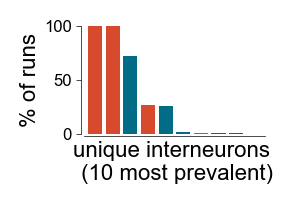

In [8]:
fig = plt.figure()
ax = orderedInPcts[:10].plot.bar(color=orderedColors[:10],width=0.8,rot=90)
plt.xticks([])
plt.ylabel("% of runs")
plt.xlabel("unique interneurons \n (10 most prevalent)")

plt.ylim([0,100])

ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=6)
fig.set_figheight(0.7)
fig.set_figwidth(1.172)
# fig.set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/minicircuitUniqueIns.svg",transparent=True)
plt.show()

## MANC 1024x DNg100 activation with CPG IN silencing

### E1 silencing

In [3]:
simType = "DNg100_Stim_Silence"
simPath = simType+"/hyak/run_id=28357120"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 4604, 2001)

In [4]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive_e1silenced = nMnsActive.copy()
simScore_e1silenced = simScore.copy()

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [5]:
del R
del Rs
del activeMnsMask
del activeMnsMaskPastTransient

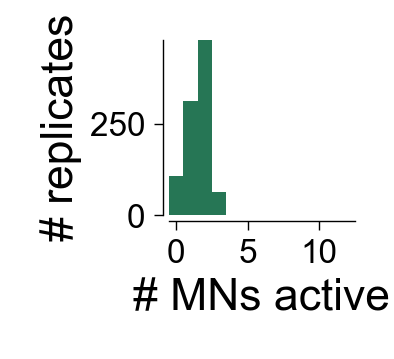

In [6]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

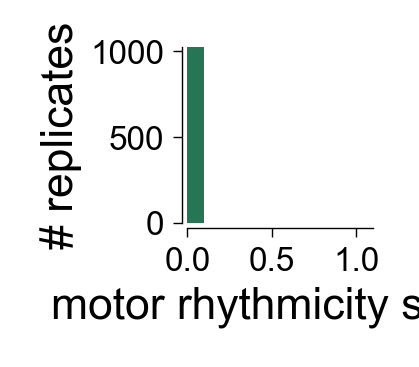

In [7]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

### E2 silencing

In [8]:
simType = "DNg100_Stim_Silence"
simPath = simType+"/hyak/run_id=28357126"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 4604, 2001)

In [9]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive_e2silenced = nMnsActive.copy()
simScore_e2silenced = simScore.copy()

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [11]:
del R
del Rs
del activeMnsMask
del activeMnsMaskPastTransient

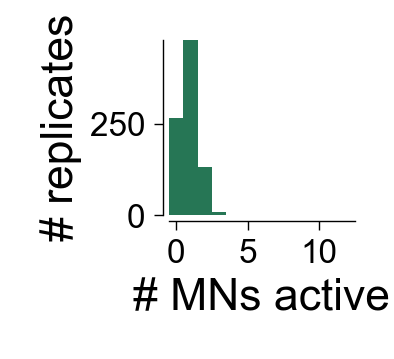

In [10]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

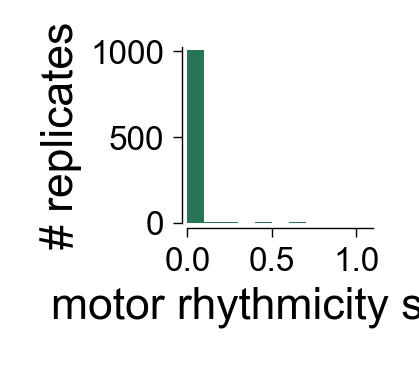

In [13]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

### I1 silencing

In [14]:
simType = "DNg100_Stim_Silence"
simPath = simType+"/hyak/run_id=28357127"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 4604, 2001)

In [15]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive_i1silenced = nMnsActive.copy()
simScore_i1silenced = simScore.copy()

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [16]:
del R
del Rs
del activeMnsMask
del activeMnsMaskPastTransient

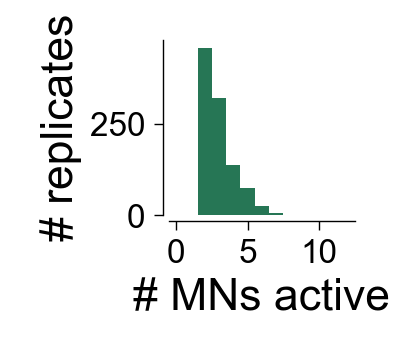

In [17]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

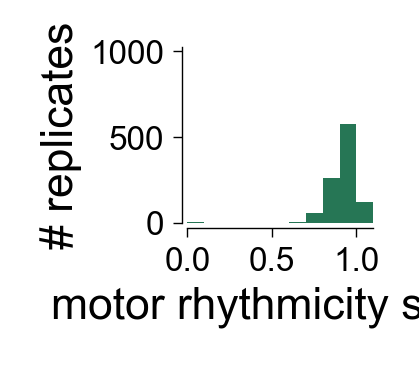

In [18]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

### combined violin plot

In [ ]:
simType = "DNg100_Stim"
simPath = simType+"/hyak/run_id=28123286"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive_intact = pd.Series(index=np.arange(nSims))
simScore_intact = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive_intact.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[:,250:],activeMnsMaskPastTransient)
    simScore_intact.loc[i] = score
    
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [25]:
nMnsActive_combined = pd.concat([nMnsActive_intact,nMnsActive_e1silenced,nMnsActive_e2silenced,nMnsActive_i1silenced],axis=1).rename(columns={0:"none",1:"E1",2:"E2",3:"I1"})
simScore_combined = pd.concat([simScore_intact,simScore_e1silenced,simScore_e2silenced,simScore_i1silenced],axis=1).rename(columns={0:"none",1:"E1",2:"E2",3:"I1"})

In [26]:
figFolder = "../figures/"
figFolder += "DNg100_Stim_Silence-combined"

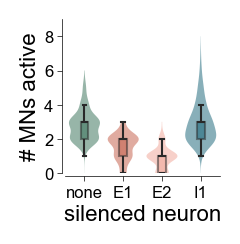

In [27]:
palette = [mnColor,excColor,lightExcColor,inhColor]

plt.figure(figsize=(1,1))
sns.violinplot(nMnsActive_combined,palette=palette,edgecolor=None,inner=None,bw_adjust=2,cut=0,alpha=0.5)
sns.boxplot(nMnsActive_combined,palette=palette,width=0.2,linewidth=0.75,fliersize=2**0.75,
            boxprops={"alpha":0.5,},showfliers=False)
plt.yticks(np.arange(0,9,2))
plt.ylim([0,9])
sns.despine(offset=1)
plt.ylabel("# MNs active")
plt.xlabel("silenced neuron")

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnViolinAndBox.svg",transparent=True)
plt.show()

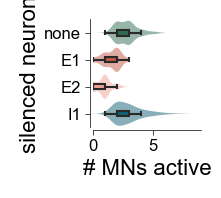

In [28]:
palette = [mnColor,excColor,lightExcColor,inhColor]

plt.figure(figsize=(0.7,0.7))
sns.violinplot(nMnsActive_combined,orient="h",palette=palette,edgecolor=None,inner=None,bw_adjust=2,cut=0,alpha=0.5,width=0.9)
sns.boxplot(nMnsActive_combined,palette=palette,width=0.2,linewidth=0.75,fliersize=2**0.75,orient="h",
            boxprops={"alpha":1.0,},showfliers=False)
plt.xticks([0,5,10])
plt.xlim([0,9])
sns.despine(offset=1)
plt.xlabel("# MNs active")
plt.ylabel("silenced neuron")

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnViolinAndBoxHor.svg",transparent=True)
plt.show()

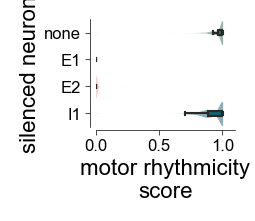

In [33]:
palette = [mnColor,excColor,lightExcColor,inhColor]

plt.figure(figsize=(0.9,0.7))

sns.violinplot(simScore_combined,palette=palette,linecolor="k",linewidth=0,inner=None,cut=0,alpha=0.5,orient="h",width=0.9)
sns.boxplot(simScore_combined,palette=palette,width=0.2,linewidth=0.75,fliersize=2**0.75,
            boxprops={"alpha":1.0,},showfliers=False,orient="h")
plt.xlim([0,1.1])
plt.xlabel("motor rhythmicity\nscore")
plt.xticks(np.arange(0,1.1,0.5))
plt.ylabel("silenced neuron")
sns.despine(offset={"left":2,"bottom":1})

# plt.gcf().set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreViolinAndBoxHor.svg",transparent=True)
plt.show()

In [34]:
nMnsActive_combined.to_csv(figFolder+"/nMnsActive.csv")
simScore_combined.to_csv(figFolder+"/scores.csv")